In [1]:
import glob

In [2]:
import matplotlib.pyplot as plt
from matplotlib import patches
import numpy as np
import pandas as pd
import seaborn.apionly as sns
%matplotlib inline

In [3]:
import re
FILENAME_PATTERN = "experiment-(\d)_user-(\d+)_run-(\d+)"
filename_regex = re.compile(pattern=FILENAME_PATTERN)

from collections import namedtuple
RunData = namedtuple("RunData", "experiment user run")
Coords = namedtuple("Coords", "x y")
TARGET = Coords(0, -6)

from enum import Enum
DroneState = Enum("DroneState",
                  "Emergency Inited Landed Flying Hovering Test TakingOff GotoHover Landing Looping",
                  start=0)
ExperimentType = Enum("ExperimentType", "Onboard Spirit Combined LineOfSight")

In [4]:
def plot_xy(df, x="x", y="y", invert_x=True, invert_y=True, s=None, c=None,
            cmap="viridis", alpha=1, show_cbar=True, label=None, line=False, zorder=0):
    """
    Coords in real frame. +x is towards doors, +y is away from table.
    
    """
    if s is not None:
        s = df[s]*25
    if c is not None:
        label = c
        try:
            df[c]
        except KeyError:
            pass
        else:
            c = df[c]
    else:
        if line:
            c = "C0"
        else:
            c = df.index
            label="time"
    
    if line:
        plt.plot(df[x] * (-1 if invert_x else 1), df[y] * (-1 if invert_y else 1), c=c, alpha=alpha, zorder=zorder)
    else:
        plt.scatter(df[x] * (-1 if invert_x else 1), df[y] * (-1 if invert_y else 1), s=s, c=c, cmap=cmap, alpha=alpha, zorder=zorder)
        if show_cbar:
            plt.colorbar(label=label)
    plt.axis("equal")

In [5]:
def plot_xy_conditional(df, condition=None, x="x", y="y", invert_x=True, invert_y=True,
                        s=None, c=None, c_condition=None, cmap_condition="viridis", cmap_not_condition="gray",
                        alpha_condition=1, alpha_not_condition=1, show_cbar=True, label=None, line=False,
                        zorder_condition=1, zorder_not_condition=0):
    if condition is None:
        cmap_not_condition = cmap_condition
    plot_xy(df, x=x, y=y, invert_x=invert_x, invert_y=invert_y,
            s=s, c=c, cmap=cmap_not_condition, alpha=alpha_not_condition, show_cbar=show_cbar,
            label=label, line=line, zorder=zorder_not_condition)
    if condition is not None:
        if line:
            show_cbar = False
            if c_condition is None:
                c = "C0"
            else:
                c = c_condition
        plot_xy(df[condition], x=x, y=y, invert_x=invert_x, invert_y=invert_y,
                s=s, c=c, cmap=cmap_condition, alpha=alpha_condition, show_cbar=show_cbar,
                label=label, zorder=zorder_condition)

In [6]:
def plot_targets(p_init=Coords(0, 0), p_final=Coords(0, 0), invert_x=True, invert_y=True,
                 target_coords=None, target_coord_offsets=None, target_color="C2",
                 target_size=Coords(0.525, 0.37), show_start=True, show_final=True,
                 scale=100, zorder=0):
    if target_coords is not None and target_coord_offsets is not None:
        raise ValueError("Use either target_coords or target_coord_offsets")
    
    ax = plt.gca()
    
    if target_coords is None:
        if target_coord_offsets is None:
            target_coord_offsets = TARGET_COORD_OFFSETS
        target_coords = [Coords(p_init.x - offset.x, p_init.y - offset.y) for offset in target_coord_offsets]
    
    if show_start:
        plt.scatter(-p_init.x, -p_init.y, marker=(5, 0), s=100, c="g")
    for coord in target_coords:
        ax.add_patch(patches.Rectangle((coord.x * (-1 if invert_x else 1) - target_size.x / 2,
                                        coord.y * (-1 if invert_y else 1) - target_size.y / 2),
                                       target_size.x,
                                       target_size.y,
                                       color=target_color,
                                       zorder=zorder))
    if show_final:
        plt.scatter(p_final.x * (-1 if invert_x else 1), p_final.y * (-1 if invert_y else 1), marker=(3, 0), s=scale, c="r")
    plt.axis("equal")

In [7]:
def tag_data(df):
    df["tag"] = (df.arrived.diff(1) != 0).astype('int').cumsum()

In [8]:
def distance(df, target):
    return np.sqrt((-df.xn - target.x)**2 + (-df.yn - target.y)**2)

In [9]:
def get_usable_filenames():
    filenames = sorted([filename for filename in glob.glob("csv/*.csv") if "user-99" not in filename])
    
    arrived_filenames = []
    for filename in filenames:
        if "user-99" not in filename:
            df = pd.read_csv(filename, parse_dates=["time"])
            if any(df.arrived):
                arrived_filenames.append(filename)
    return arrived_filenames

In [10]:
def extract_run_data(filename):
    data = filename_regex.findall(filename)[0]
    return RunData(ExperimentType(int(data[0])), int(data[1]), int(data[2]))

In [11]:
def analyze_all():
    filenames = get_usable_filenames()
    results = pd.DataFrame(columns="user experiment run dist_err x_err y_err".split() +
                                    "dist_std x_std y_std rms rms_x rms_y".split())
    
    for i, filename in enumerate(filenames):
        data = extract_run_data(filename)
        df = pd.read_csv(filename, parse_dates=["time"])
        found = df[df.arrived == 1]

        distances = distance(found, TARGET)
        dist_err = distances.mean()
        dist_std = distances.std()

        dx = found.xn - TARGET.x
        x_err = dx.mean()
        x_std = dx.std()

        dy = found.yn - TARGET.y
        y_err = dy.mean()
        y_std = dy.std()

        rms = np.sqrt(np.mean(((found.xn - TARGET.x)**2 + (found.yn - TARGET.y)**2)))
        rms_x = np.sqrt(np.mean((dx)**2))
        rms_y = np.sqrt(np.mean((dy)**2))
        results.loc[i] = [
            data.user, data.experiment, data.run,
            dist_err, x_err, y_err,
            dist_std, x_std, y_std,
            rms, rms_x, rms_y
        ]
    
    return results

In [12]:
def load_all():
    filenames = get_usable_filenames()
    frames = []
    for filename in filenames:
        df = pd.read_csv(filename, parse_dates=["time"])
        data = extract_run_data(filename)
        df["experiment"] = data.experiment
        df["user"] = data.user
        df["run"] = data.run
        frames.append(df)
    result = pd.concat(frames, ignore_index=True)
    result.xn *= -1
    result.yn *= -1
    return result

Import the files.

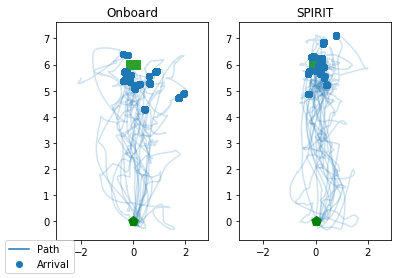

In [13]:
ax1 = plt.subplot("121")
for filename in glob.glob("csv/experiment-1_*.csv"):
    if "user-99" not in filename:
        df = pd.read_csv(filename, parse_dates=["time"])
        if any(df.arrived):
            plot_xy_conditional(df, df.arrived==1, x="xn", y="yn", c="C0", c_condition="C0",
                                alpha_not_condition=0.2, alpha_condition=0.5, line=True,
                                zorder_condition=1, zorder_not_condition=0)
plot_targets(target_coords=[TARGET], show_final=False, zorder=-1)
plt.title("Onboard")

ax2 = plt.subplot("122", sharex=ax1, sharey=ax1)
for filename in glob.glob("csv/experiment-2_*.csv"):
    if "user-99" not in filename:
        df = pd.read_csv(filename, parse_dates=["time"])
        if any(df.arrived):
            plot_xy_conditional(df, df.arrived==1, x="xn", y="yn", c="C0", c_condition="C0",
                                alpha_not_condition=0.2, alpha_condition=0.5, line=True,
                                zorder_condition=1, zorder_not_condition=0)
plot_targets(target_coords=[TARGET], show_final=False, zorder=-1)
plt.title("SPIRIT")
spirit_path, = plt.plot([], [], color="C0")
spirit_arrival, = plt.plot([], [], linestyle="none", color="C0", marker="o")
plt.figlegend([spirit_path, spirit_arrival], ["Path", "Arrival"], "lower left")

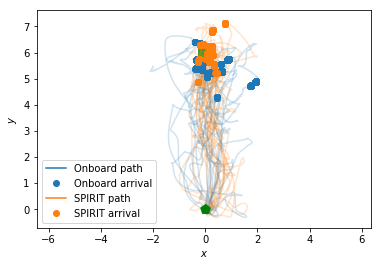

In [14]:
for filename in glob.glob("csv/experiment-1_*.csv"):
    if "user-99" not in filename:
        df = pd.read_csv(filename, parse_dates=["time"])
        if any(df.arrived):
            plot_xy_conditional(df, df.arrived==1, x="xn", y="yn", c="C0", c_condition="C0",
                                alpha_not_condition=0.2, alpha_condition=0.5, line=True,
                                zorder_condition=1, zorder_not_condition=0)
onboard_path, = plt.plot([], [], color="C0", label="Onboard path")
onboard_arrival, = plt.plot([], [], linestyle="none", color="C0", marker="o", label="Onboard arrival")
for filename in glob.glob("csv/experiment-2_*.csv"):
    if "user-99" not in filename:
        df = pd.read_csv(filename, parse_dates=["time"])
        if any(df.arrived):
            plot_xy_conditional(df, df.arrived==1, x="xn", y="yn", c="C1", c_condition="C1",
                                alpha_not_condition=0.2, alpha_condition=0.5, line=True,
                                zorder_condition=1, zorder_not_condition=0)
spirit_path, = plt.plot([], [], color="C1", label="SPIRIT path")
spirit_arrival, = plt.plot([], [], linestyle="none", color="C1", marker="o", label="SPIRIT arrival")
plot_targets(target_coords=[TARGET], show_final=False, zorder=-1)
plt.xlabel(r"$x$")
plt.ylabel(r"$y$")
plt.legend(handles=[onboard_path, onboard_arrival, spirit_path, spirit_arrival])

Check not too many multiple arrivals.

In [15]:
filenames = get_usable_filenames()

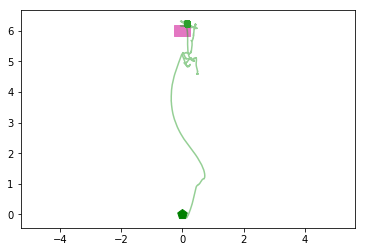

In [16]:
df = pd.read_csv(filenames[19], parse_dates=["time"])
plot_targets(target_coords=[TARGET], target_color="C6", show_final=False, zorder=0)
plot_xy_conditional(df, df.arrived==1, x="xn", y="yn", c="C2", c_condition="C2",
                    alpha_not_condition=0.5, alpha_condition=0.5, line=True)

# Mega dataframe

In [143]:
analyses = analyze_all()
analyses.head()

,user,experiment,run,dist_err,x_err,y_err,dist_std,x_std,y_std,rms,rms_x,rms_y
0,0.0,ExperimentType.Onboard,0.0,10.996625,-1.867368,1.163346,0.087898,0.088919,0.074071,2.203121,1.869470,1.165686
1,0.0,ExperimentType.Onboard,1.0,10.293345,-0.451036,1.716546,0.002297,0.009593,0.002709,1.774841,0.451137,1.716548
2,1.0,ExperimentType.Onboard,0.0,11.217431,0.030240,0.783010,0.132141,0.095295,0.131885,0.800242,0.099796,0.793995
3,1.0,ExperimentType.Onboard,1.0,11.214037,-0.152469,0.787043,0.005716,0.031529,0.005290,0.802308,0.155673,0.787061
4,2.0,ExperimentType.Onboard,0.0,11.730682,-0.822639,0.298607,0.071337,0.102400,0.064994,0.883466,0.828945,0.305552


In [145]:
results = load_all()

In [19]:
results.head()

,time,arrived,angle,gx,gy,qa,qb,qc,qd,x,y,z,xn,yn,experiment,user,run
0,2017-02-02 12:52:17.209465088,0.0,-0.016687,0.019967,2.763791,0.998033,0.062036,-0.003863,-0.008119,0.019967,2.763791,0.104676,-0.000000,-0.000000,ExperimentType.Onboard,0,0
1,2017-02-02 12:52:17.209335808,0.0,-0.016687,0.019967,2.763791,0.998033,0.062036,-0.003863,-0.008119,0.019967,2.763791,0.104676,-0.000000,-0.000000,ExperimentType.Onboard,0,0
2,2017-02-02 12:52:17.218366976,0.0,-0.023381,0.022095,2.764871,0.998033,0.062036,-0.003863,-0.008119,0.019967,2.763791,0.104676,-0.000000,-0.000000,ExperimentType.Onboard,0,0
3,2017-02-02 12:52:17.218175232,0.0,-0.023381,0.022095,2.764871,0.999872,0.010817,-0.001526,-0.011675,0.022095,2.764871,0.097777,-0.002129,-0.001081,ExperimentType.Onboard,0,0
4,2017-02-02 12:52:17.225977344,0.0,-0.023381,0.022095,2.764871,0.999047,0.042725,-0.003813,-0.008046,0.020350,2.764282,0.101648,-0.000383,-0.000491,ExperimentType.Onboard,0,0


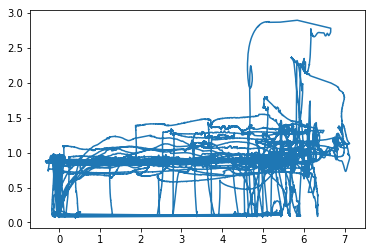

In [20]:
plt.plot(results.yn, results.z)

In [173]:
analyses["group"] = analyses.user % 2
analyses["order"] = [1, 2, 3, 4]*(len(analyses)//4)
results["group"] = results.user % 2
results["distance"] = distance(results, TARGET)
results["order"] = (((results.run.diff(1) != 0) | (results.user.diff(1) != 0)).astype('int').cumsum() - 1) % 4 + 1

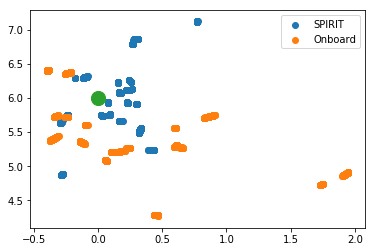

In [192]:
spirit_arrived = results[(results.arrived==1) & (results.experiment==ExperimentType.Spirit)]
onboard_arrived = results[(results.arrived==1) & (results.experiment==ExperimentType.Onboard)]
plt.scatter(spirit_arrived.xn, spirit_arrived.yn, label="SPIRIT")
plt.scatter(onboard_arrived.xn, onboard_arrived.yn, label="Onboard")
plt.scatter(0, 6, s=200)
plt.legend()

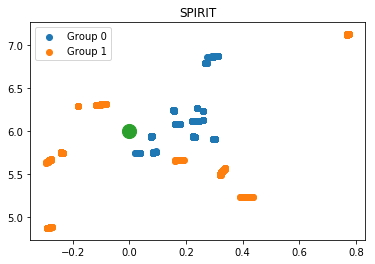

In [23]:
plt.scatter(spirit_arrived[spirit_arrived.group==0].xn, spirit_arrived[spirit_arrived.group==0].yn, label="Group 0")
plt.scatter(spirit_arrived[spirit_arrived.group==1].xn, spirit_arrived[spirit_arrived.group==1].yn, label="Group 1")
plt.scatter(0, 6, s=200)
plt.title("SPIRIT")
plt.legend()

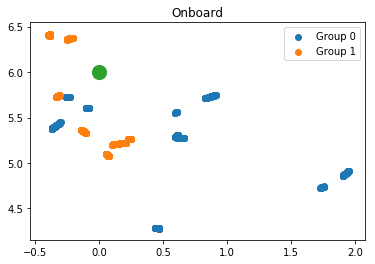

In [24]:
plt.scatter(onboard_arrived[onboard_arrived.group==0].xn, onboard_arrived[onboard_arrived.group==0].yn, label="Group 0")
plt.scatter(onboard_arrived[onboard_arrived.group==1].xn, onboard_arrived[onboard_arrived.group==1].yn, label="Group 1")
plt.scatter(0, 6, s=200)
plt.title("Onboard")
plt.legend()

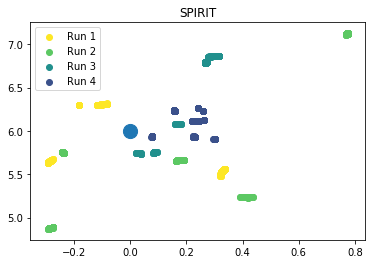

In [93]:
plt.scatter(spirit_arrived[spirit_arrived.order==1].xn, spirit_arrived[spirit_arrived.order==1].yn, label="Run 1", c=plt.get_cmap("viridis").colors[255])
plt.scatter(spirit_arrived[spirit_arrived.order==2].xn, spirit_arrived[spirit_arrived.order==2].yn, label="Run 2", c=plt.get_cmap("viridis").colors[191])
plt.scatter(spirit_arrived[spirit_arrived.order==3].xn, spirit_arrived[spirit_arrived.order==3].yn, label="Run 3", c=plt.get_cmap("viridis").colors[127])
plt.scatter(spirit_arrived[spirit_arrived.order==4].xn, spirit_arrived[spirit_arrived.order==4].yn, label="Run 4", c=plt.get_cmap("viridis").colors[63])
plt.scatter(0, 6, s=200)
plt.title("SPIRIT")
plt.legend()

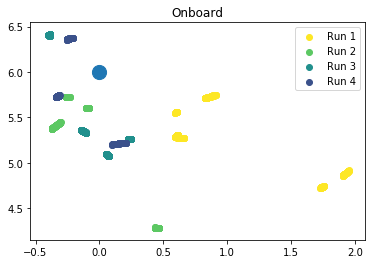

In [94]:
plt.scatter(onboard_arrived[onboard_arrived.order==1].xn, onboard_arrived[onboard_arrived.order==1].yn, label="Run 1", c=plt.get_cmap("viridis").colors[255])
plt.scatter(onboard_arrived[onboard_arrived.order==2].xn, onboard_arrived[onboard_arrived.order==2].yn, label="Run 2", c=plt.get_cmap("viridis").colors[191])
plt.scatter(onboard_arrived[onboard_arrived.order==3].xn, onboard_arrived[onboard_arrived.order==3].yn, label="Run 3", c=plt.get_cmap("viridis").colors[127])
plt.scatter(onboard_arrived[onboard_arrived.order==4].xn, onboard_arrived[onboard_arrived.order==4].yn, label="Run 4", c=plt.get_cmap("viridis").colors[63])
plt.scatter(0, 6, s=200)
plt.title("Onboard")
plt.legend()

In [27]:
analyses

,user,experiment,run,dist_err,x_err,y_err,dist_std,x_std,y_std,rms,rms_x,rms_y,group,order
0,0.0,ExperimentType.Onboard,0.0,10.996625,-1.867368,1.163346,0.087898,0.088919,0.074071,2.203121,1.869470,1.165686,0.0,1
1,0.0,ExperimentType.Onboard,1.0,10.293345,-0.451036,1.716546,0.002297,0.009593,0.002709,1.774841,0.451137,1.716548,0.0,2
2,1.0,ExperimentType.Onboard,0.0,11.217431,0.030240,0.783010,0.132141,0.095295,0.131885,0.800242,0.099796,0.793995,1.0,3
3,1.0,ExperimentType.Onboard,1.0,11.214037,-0.152469,0.787043,0.005716,0.031529,0.005290,0.802308,0.155673,0.787061,1.0,4
4,2.0,ExperimentType.Onboard,0.0,11.730682,-0.822639,0.298607,0.071337,0.102400,0.064994,0.883466,0.828945,0.305552,0.0,1
5,2.0,ExperimentType.Onboard,2.0,11.415123,0.341027,0.589991,0.020707,0.020094,0.021315,0.682085,0.341614,0.590373,0.0,2
6,3.0,ExperimentType.Onboard,0.0,12.413120,0.389429,-0.407009,0.003661,0.004213,0.003704,0.563332,0.389452,0.407026,1.0,3
7,3.0,ExperimentType.Onboard,1.0,12.371597,0.230236,-0.369447,0.004961,0.013742,0.005207,0.435561,0.230642,0.369483,1.0,4
8,4.0,ExperimentType.Onboard,0.0,11.295291,-0.626776,0.722130,0.001871,0.019826,0.002902,0.956408,0.627086,0.722136,0.0,1
9,4.0,ExperimentType.Onboard,1.0,11.604014,0.092748,0.396358,0.002216,0.006316,0.002166,0.407119,0.092958,0.396364,0.0,2


In [28]:
analyses[analyses.group == 0].rms.mean()

0.67435106579040993

In [29]:
analyses[analyses.group == 1].rms.mean()

0.63771681301069527

In [30]:
analyses[analyses.experiment == ExperimentType.Spirit].dist_err.mean()

11.940645966675563

In [31]:
analyses[analyses.experiment == ExperimentType.Onboard].rms.mean()

0.85724746043800659

In [32]:
analyses[(analyses.experiment == ExperimentType.Spirit) & (analyses.group == 0)].rms.mean()

0.32309553774994576

In [33]:
analyses[(analyses.experiment == ExperimentType.Spirit) & (analyses.group == 1)].rms.mean()

0.64266501010720811

In [34]:
analyses[(analyses.experiment == ExperimentType.Onboard) & (analyses.group == 0)].rms.mean()

1.0256065938308743

In [35]:
analyses[(analyses.experiment == ExperimentType.Onboard) & (analyses.group == 1)].rms.mean()

0.63276861591418265

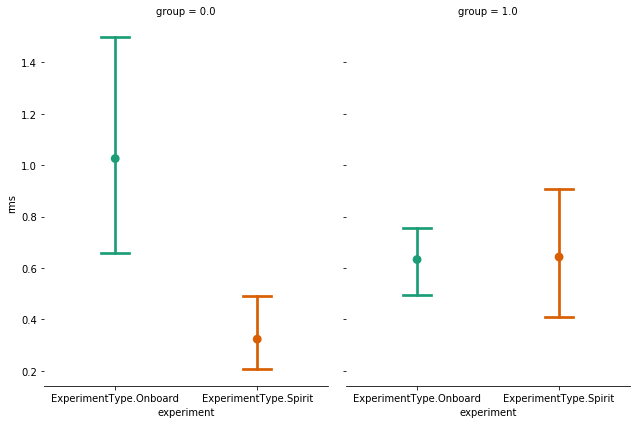

In [36]:
g = sns.factorplot(x="experiment", y="rms", col="group", data=analyses,
                   capsize=.2, palette="Dark2", size=6, aspect=.75)
g.despine(left=True)

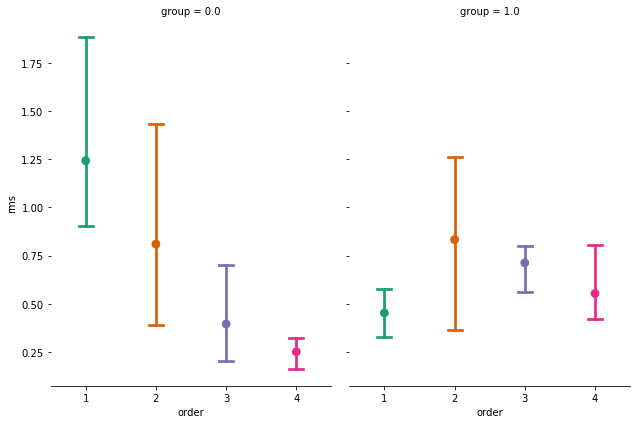

In [37]:
g = sns.factorplot(x="order", y="rms", col="group", data=analyses,
                   capsize=.2, palette="Dark2", size=6, aspect=.75)
g.despine(left=True)

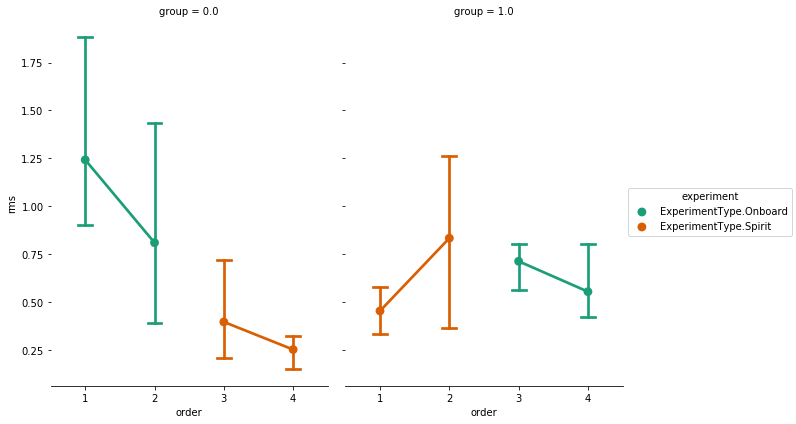

In [38]:
g = sns.factorplot(x="order", y="rms", col="group", hue="experiment", data=analyses,
                   capsize=.2, palette="Dark2", size=6, aspect=.75)
g.despine(left=True)

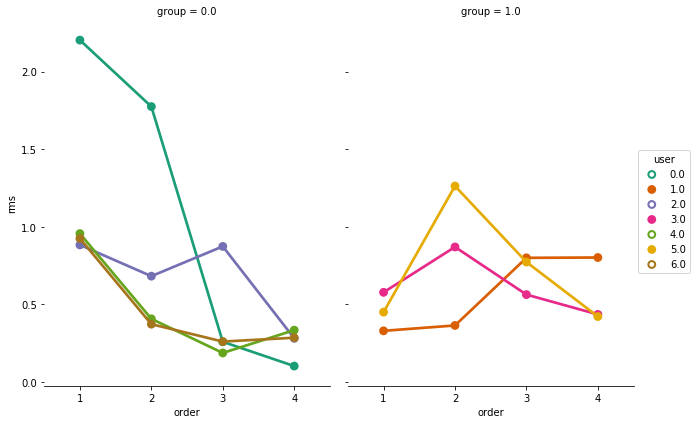

In [39]:
g = sns.factorplot(x="order", y="rms", hue="user", col="group", data=analyses,
                   capsize=.2, palette="Dark2", size=6, aspect=.75)
g.despine(left=True)

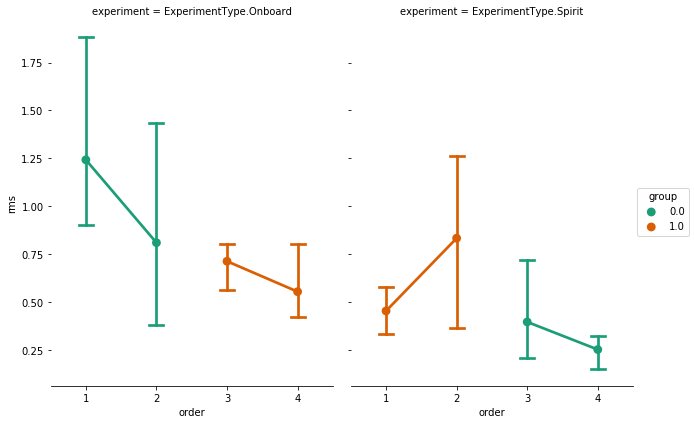

In [40]:
g = sns.factorplot(x="order", y="rms", hue="group", col="experiment", data=analyses,
                   capsize=.2, palette="Dark2", size=6, aspect=.75)
g.despine(left=True)

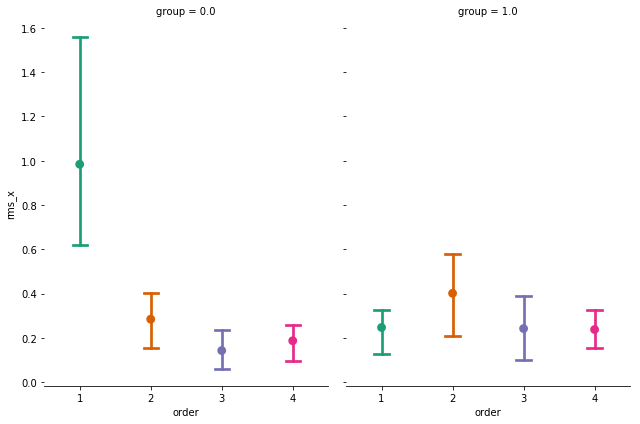

In [41]:
g = sns.factorplot(x="order", y="rms_x", col="group", data=analyses,
                   capsize=.2, palette="Dark2", size=6, aspect=.75)
g.despine(left=True)

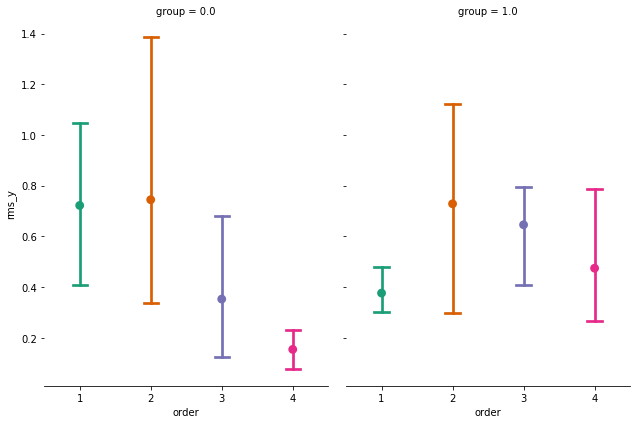

In [42]:
g = sns.factorplot(x="order", y="rms_y", col="group", data=analyses,
                   capsize=.2, palette="Dark2", size=6, aspect=.75)
g.despine(left=True)

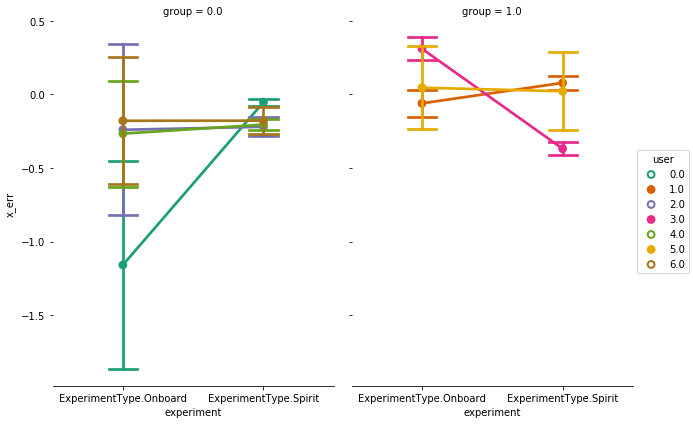

In [43]:
g = sns.factorplot(x="experiment", y="x_err", col="group", hue="user", data=analyses,
                   capsize=.2, palette="Dark2", size=6, aspect=.75)
g.despine(left=True)

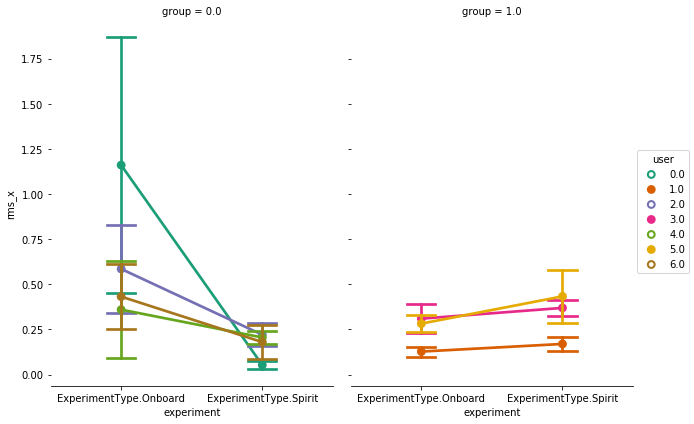

In [44]:
g = sns.factorplot(x="experiment", y="rms_x", col="group", hue="user", data=analyses,
                   capsize=.2, palette="Dark2", size=6, aspect=.75)
g.despine(left=True)

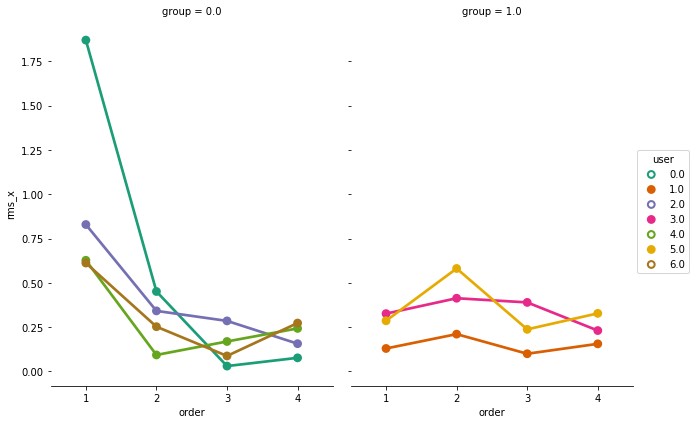

In [45]:
g = sns.factorplot(x="order", y="rms_x", col="group", hue="user", data=analyses,
                   capsize=.2, palette="Dark2", size=6, aspect=.75)
g.despine(left=True)

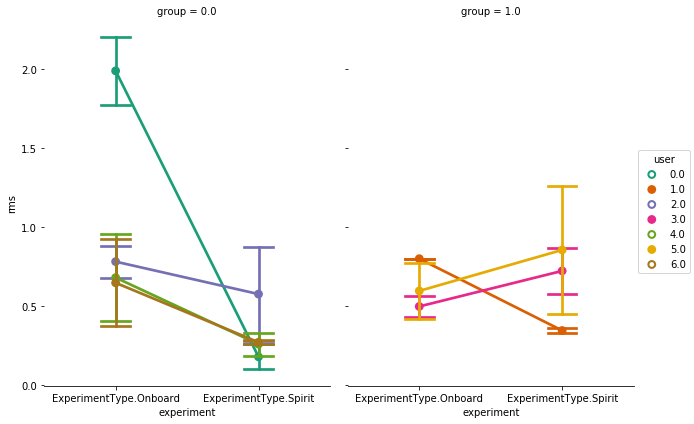

In [46]:
g = sns.factorplot(x="experiment", y="rms", col="group", hue="user", data=analyses,
                   capsize=.2, palette="Dark2", size=6, aspect=.75)
g.despine(left=True)

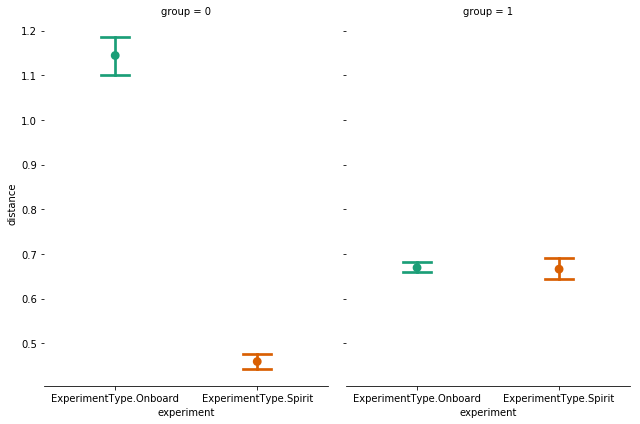

In [47]:
g = sns.factorplot(x="experiment", y="distance", col="group", data=results[results.arrived==1],
                   capsize=.2, palette="Dark2", size=6, aspect=.75)
g.despine(left=True)

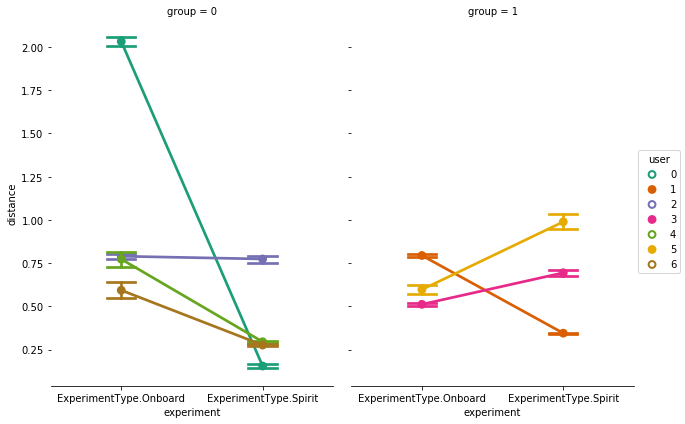

In [48]:
g = sns.factorplot(x="experiment", y="distance", col="group", hue="user", data=results[results.arrived==1],
                   capsize=.2, palette="Dark2", size=6, aspect=.75)
g.despine(left=True)

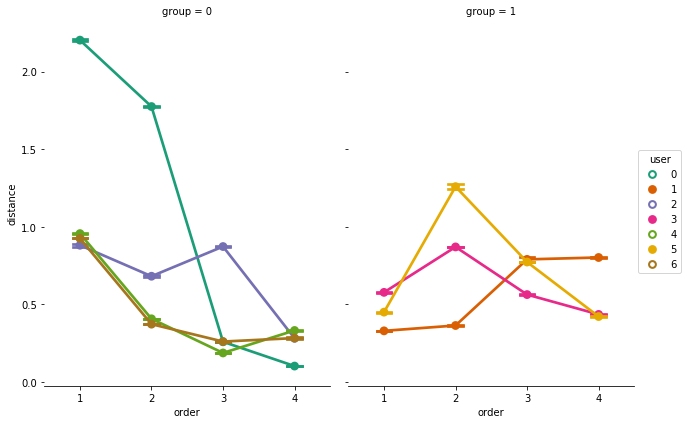

In [49]:
g = sns.factorplot(x="order", y="distance", col="group", hue="user", data=results[results.arrived==1],
                   capsize=.2, palette="Dark2", size=6, aspect=.75)
g.despine(left=True)

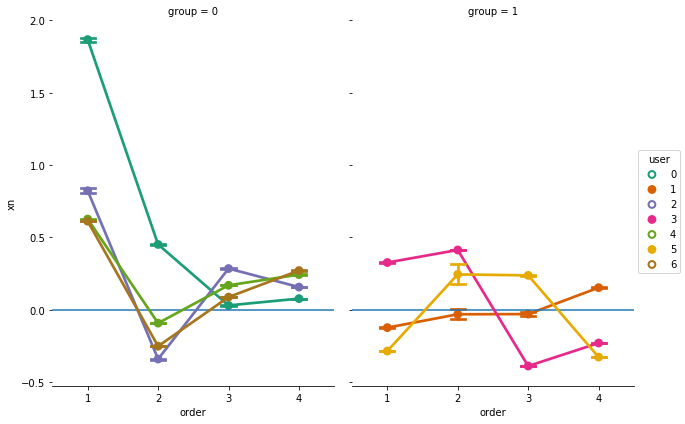

In [50]:
g = sns.factorplot(x="order", y="xn", col="group", hue="user", data=results[results.arrived==1],
                   capsize=.2, palette="Dark2", size=6, aspect=.75)
g.despine(left=True)
g.axes[0][0].axhline(0)
g.axes[0][1].axhline(0)

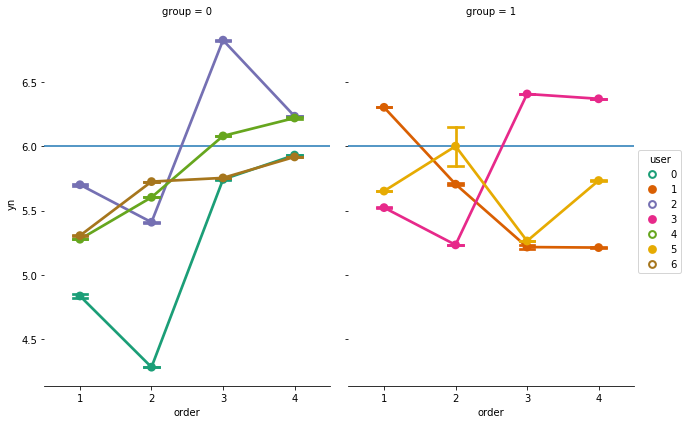

In [51]:
g = sns.factorplot(x="order", y="yn", col="group", hue="user", data=results[results.arrived==1],
                   capsize=.2, palette="Dark2", size=6, aspect=.75)
g.despine(left=True)
g.axes[0][0].axhline(6)
g.axes[0][1].axhline(6)

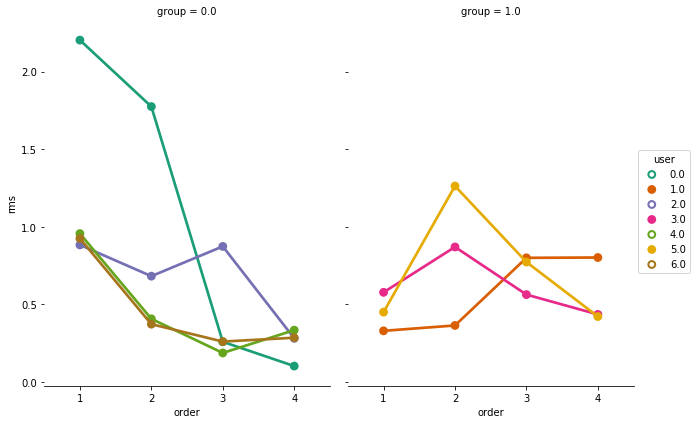

In [52]:
g = sns.factorplot(x="order", y="rms", col="group", hue="user", data=analyses,
                   capsize=.2, palette="Dark2", size=6, aspect=.75)
g.despine(left=True)

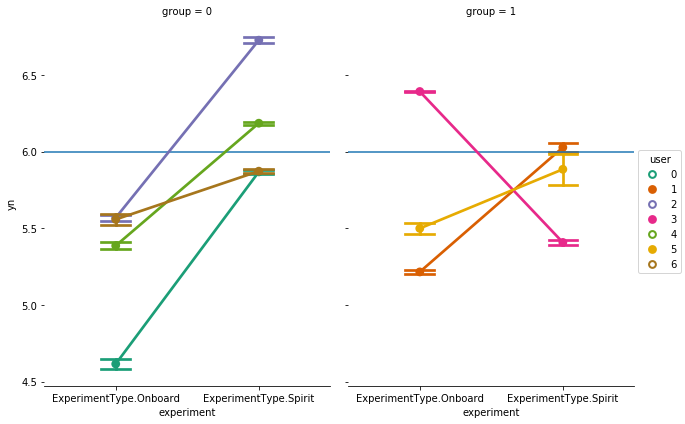

In [53]:
g = sns.factorplot(x="experiment", y="yn", col="group", hue="user", data=results[results.arrived==1],
                   capsize=.2, palette="Dark2", size=6, aspect=.75)
g.despine(left=True)
g.axes[0][0].axhline(6)
g.axes[0][1].axhline(6)

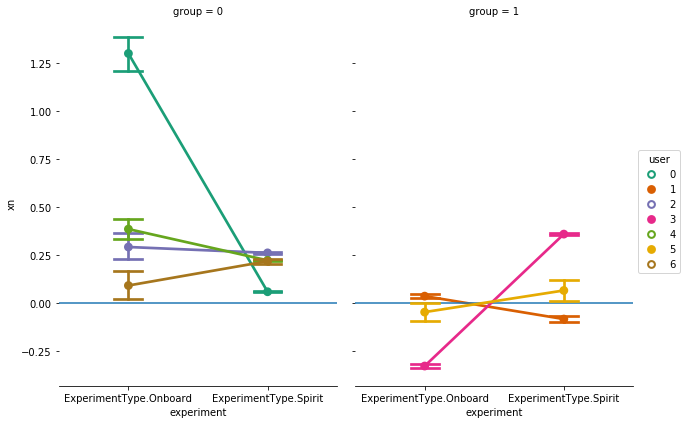

In [54]:
g = sns.factorplot(x="experiment", y="xn", col="group", hue="user", data=results[results.arrived==1],
                   capsize=.2, palette="Dark2", size=6, aspect=.75)
g.despine(left=True)
g.axes[0][0].axhline(0)
g.axes[0][1].axhline(0)

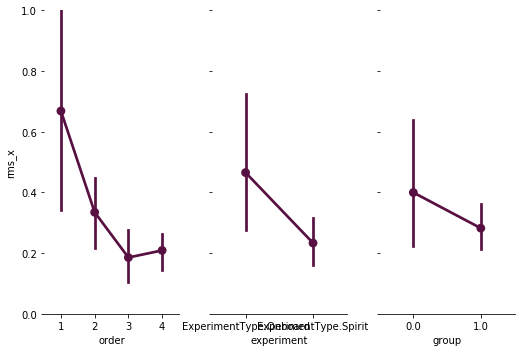

In [55]:
g = sns.PairGrid(analyses, y_vars="rms_x",
                 x_vars=["order", "experiment", "group"],
                 size=5, aspect=.5)

# Draw a seaborn pointplot onto each Axes
g.map(sns.pointplot, color=sns.xkcd_rgb["plum"])
g.set(ylim=(0, 1))
sns.despine(fig=g.fig, left=True)

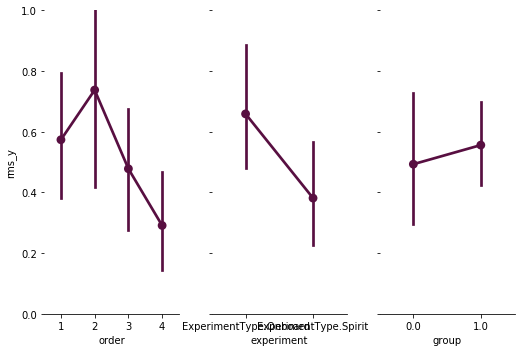

In [56]:
g = sns.PairGrid(analyses, y_vars="rms_y",
                 x_vars=["order", "experiment", "group"],
                 size=5, aspect=.5)

# Draw a seaborn pointplot onto each Axes
g.map(sns.pointplot, color=sns.xkcd_rgb["plum"])
g.set(ylim=(0, 1))
sns.despine(fig=g.fig, left=True)

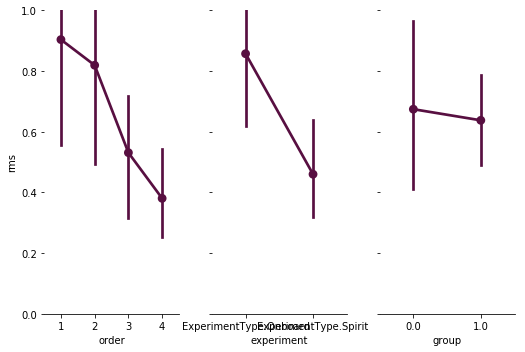

In [57]:
g = sns.PairGrid(analyses, y_vars="rms",
                 x_vars=["order", "experiment", "group"],
                 size=5, aspect=.5)

# Draw a seaborn pointplot onto each Axes
g.map(sns.pointplot, color=sns.xkcd_rgb["plum"])
g.set(ylim=(0, 1))
sns.despine(fig=g.fig, left=True)

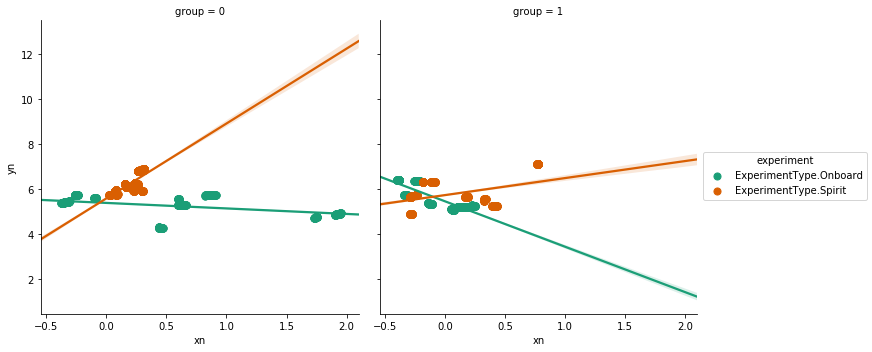

In [58]:
sns.lmplot(x="xn", y="yn", col="group", hue="experiment", data=results[results.arrived==1],
           col_wrap=2, palette="Dark2",
           scatter_kws={"s": 50, "alpha": 1})

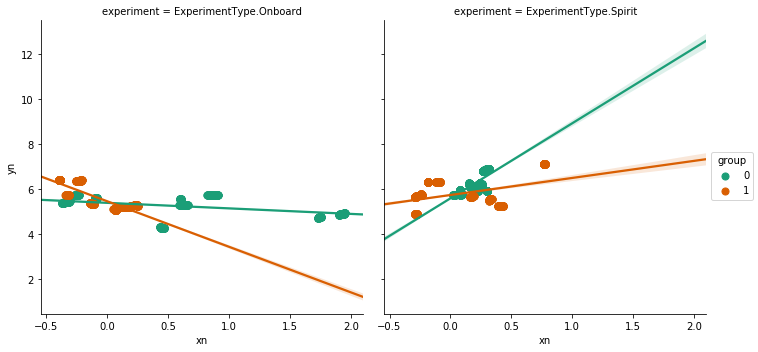

In [59]:
sns.lmplot(x="xn", y="yn", col="experiment", hue="group", data=results[results.arrived==1],
           col_wrap=2, palette="Dark2",
           scatter_kws={"s": 50, "alpha": 1})

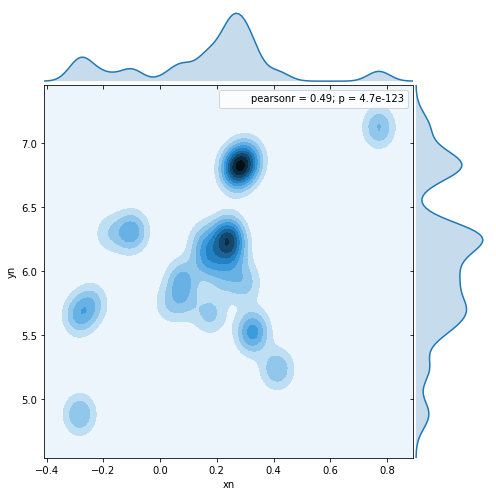

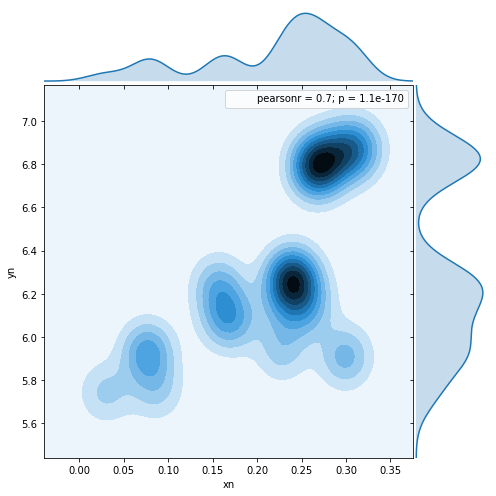

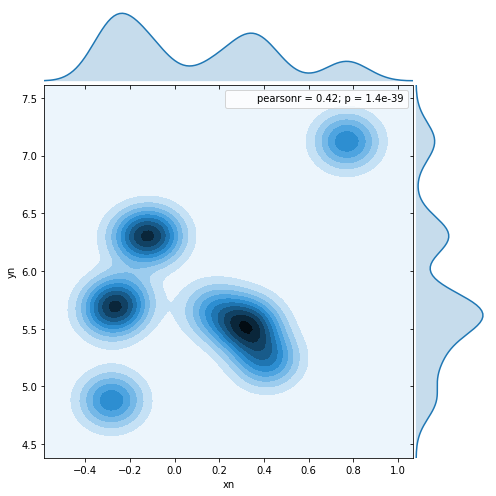

In [77]:
g = sns.jointplot(spirit_arrived.xn, spirit_arrived.yn, kind="kde", size=7, space=0)
g = sns.jointplot(spirit_arrived[spirit_arrived.group==0].xn, spirit_arrived[spirit_arrived.group==0].yn, kind="kde", size=7, space=0)
g = sns.jointplot(spirit_arrived[spirit_arrived.group==1].xn, spirit_arrived[spirit_arrived.group==1].yn, kind="kde", size=7, space=0)

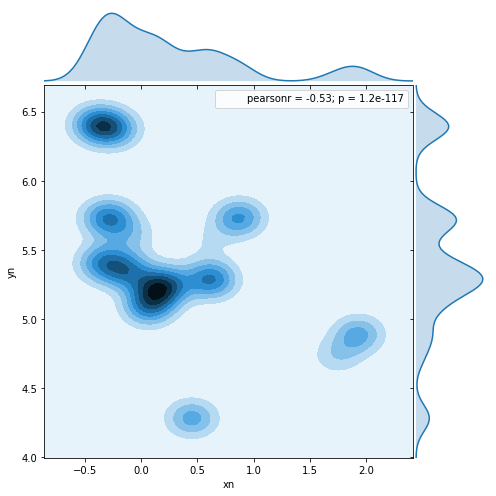

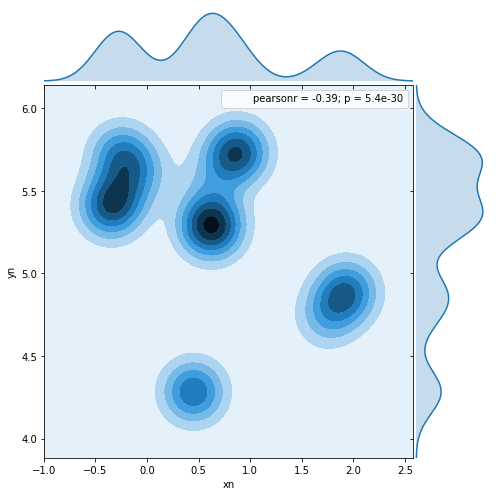

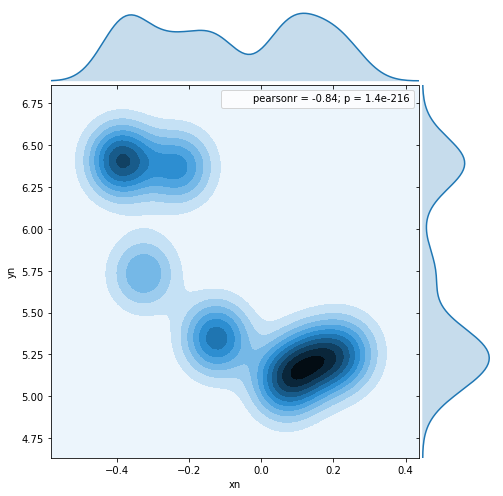

In [78]:
g = sns.jointplot(onboard_arrived.xn, onboard_arrived.yn, kind="kde", size=7, space=0)
g = sns.jointplot(onboard_arrived[onboard_arrived.group==0].xn, onboard_arrived[onboard_arrived.group==0].yn, kind="kde", size=7, space=0)
g = sns.jointplot(onboard_arrived[onboard_arrived.group==1].xn, onboard_arrived[onboard_arrived.group==1].yn, kind="kde", size=7, space=0)

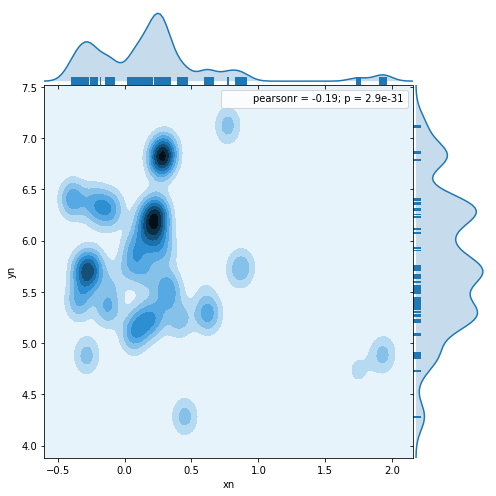

In [62]:
g = sns.jointplot(results[results.arrived==1].xn, results[results.arrived==1].yn, kind="kde", size=7, space=0)
g.plot_marginals(sns.rugplot, height=0.1)

In [193]:
analyses["experiment_int"] = [e.value for e in analyses.experiment]
results["experiment_int"] = [e.value for e in results.experiment]

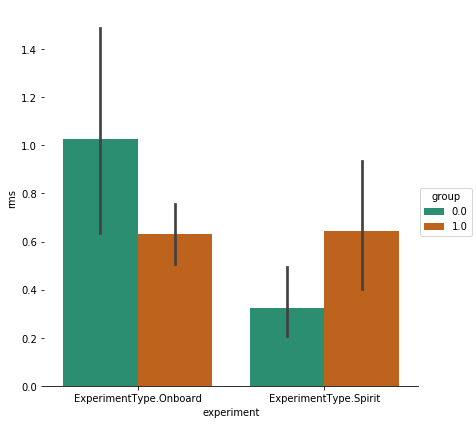

In [185]:
g = sns.factorplot(x="experiment", y="rms", hue="group", data=analyses,
                   size=6, kind="bar", palette="Dark2")
g.despine(left=True)

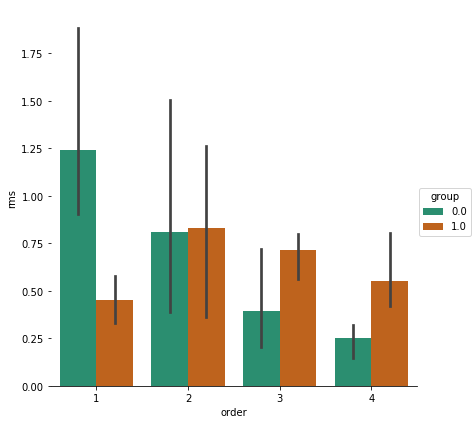

In [186]:
g = sns.factorplot(x="order", y="rms", hue="group", data=analyses,
                   size=6, kind="bar", palette="Dark2")
g.despine(left=True)

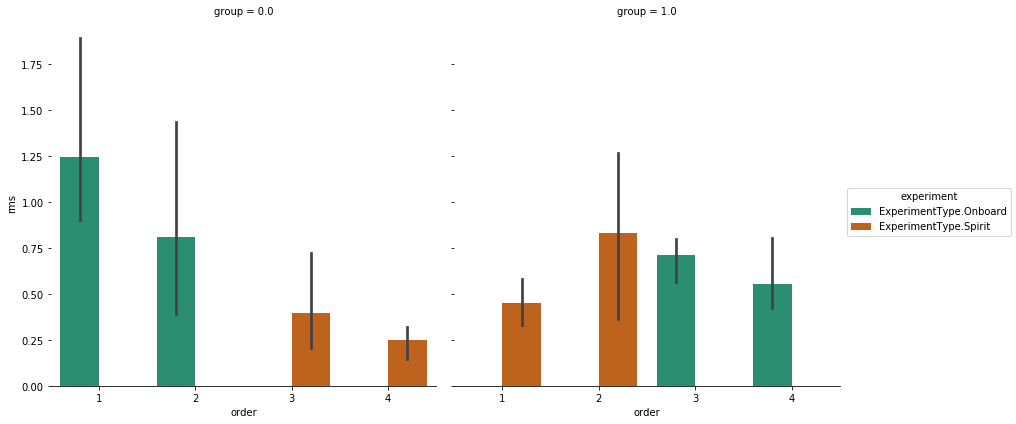

In [187]:
g = sns.factorplot(x="order", y="rms", hue="experiment", col="group", data=analyses,
                   size=6, kind="bar", palette="Dark2")
g.despine(left=True)

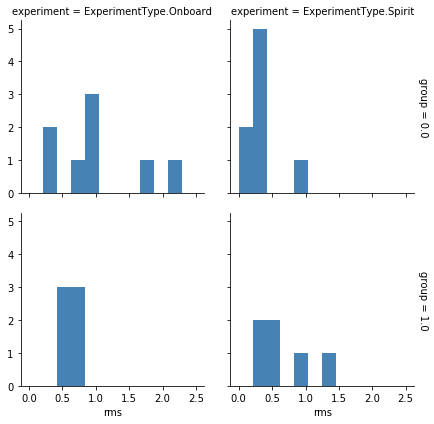

In [189]:
g = sns.FacetGrid(analyses, row="group", col="experiment", margin_titles=True)
bins = np.linspace(0, 2.5, 13)
g.map(plt.hist, "rms", color="steelblue", bins=bins, lw=0)

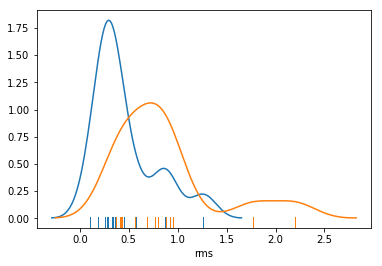

In [190]:
sns.distplot(analyses[analyses.experiment == ExperimentType.Spirit].rms, hist=False, rug=True, color="C0")
sns.distplot(analyses[analyses.experiment == ExperimentType.Onboard].rms, hist=False, rug=True, color="C1")

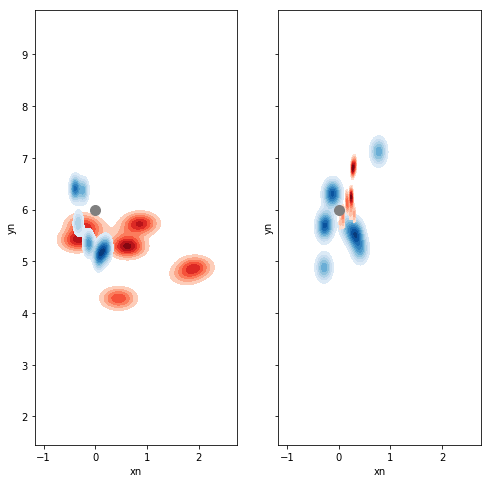

In [68]:
f, axes = plt.subplots(1, 2, figsize=(8, 8), sharex=True, sharey=True)
axes[0].set_aspect("equal")
axes[1].set_aspect("equal")

sns.kdeplot(onboard_arrived[onboard_arrived.group==0].xn, onboard_arrived[onboard_arrived.group==0].yn,
            cmap="Reds", shade=True, shade_lowest=False, ax=axes[0])
sns.kdeplot(onboard_arrived[onboard_arrived.group==1].xn, onboard_arrived[onboard_arrived.group==1].yn,
            cmap="Blues", shade=True, shade_lowest=False, ax=axes[0])

axes[0].scatter(0, 6, c="C7", s=100)

sns.kdeplot(spirit_arrived[spirit_arrived.group==1].xn, spirit_arrived[spirit_arrived.group==1].yn,
            cmap="Blues", shade=True, shade_lowest=False, ax=axes[1])
sns.kdeplot(spirit_arrived[spirit_arrived.group==0].xn, spirit_arrived[spirit_arrived.group==0].yn,
            cmap="Reds", shade=True, shade_lowest=False, ax=axes[1])

axes[1].scatter(0, 6, c="C7", s=100)

/home/masasin/.pyenv/versions/3.6.0/envs/scipy_stack/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


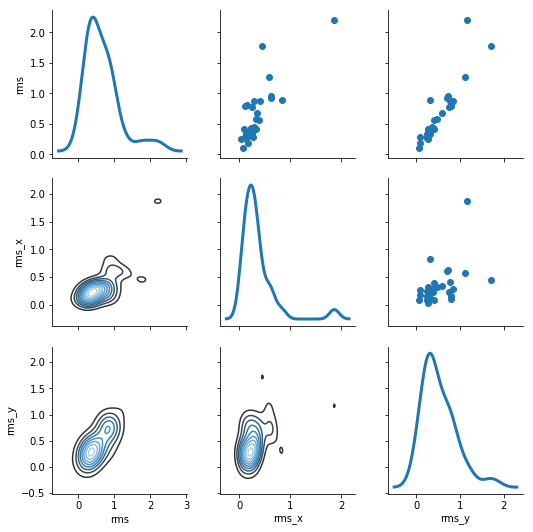

In [196]:
g = sns.PairGrid(analyses[["rms", "rms_x", "rms_y"]], diag_sharey=False)
g.map_lower(sns.kdeplot, cmap="Blues_d")
g.map_upper(plt.scatter)
g.map_diag(sns.kdeplot, lw=3)

/home/masasin/.pyenv/versions/3.6.0/envs/scipy_stack/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


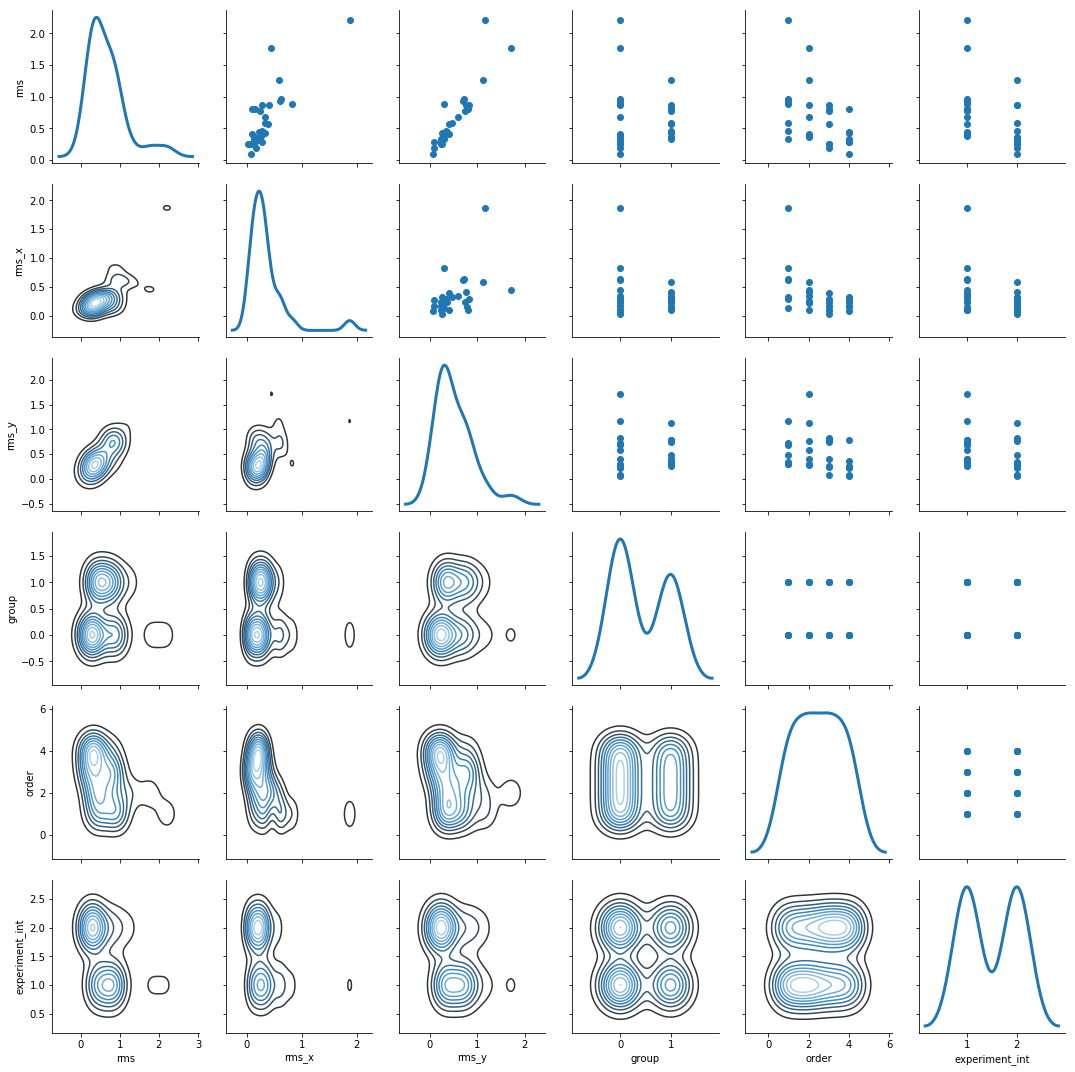

In [195]:
g = sns.PairGrid(analyses[["rms", "rms_x", "rms_y", "group", "order", "experiment_int"]], diag_sharey=False)
g.map_lower(sns.kdeplot, cmap="Blues_d")
g.map_upper(plt.scatter)
g.map_diag(sns.kdeplot, lw=3)

/home/masasin/.pyenv/versions/3.6.0/envs/scipy_stack/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


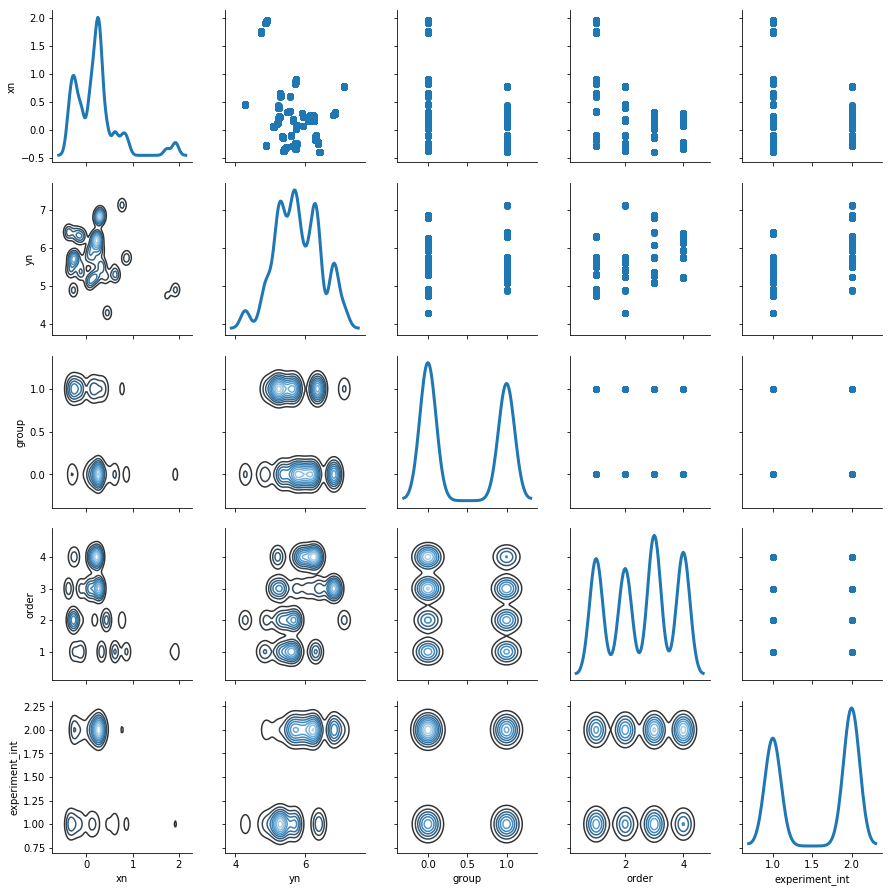

In [70]:
g = sns.PairGrid(results[results.arrived==1][["xn", "yn", "group", "order", "experiment_int"]], diag_sharey=False)
g.map_lower(sns.kdeplot, cmap="Blues_d")
g.map_upper(plt.scatter)
g.map_diag(sns.kdeplot, lw=3)

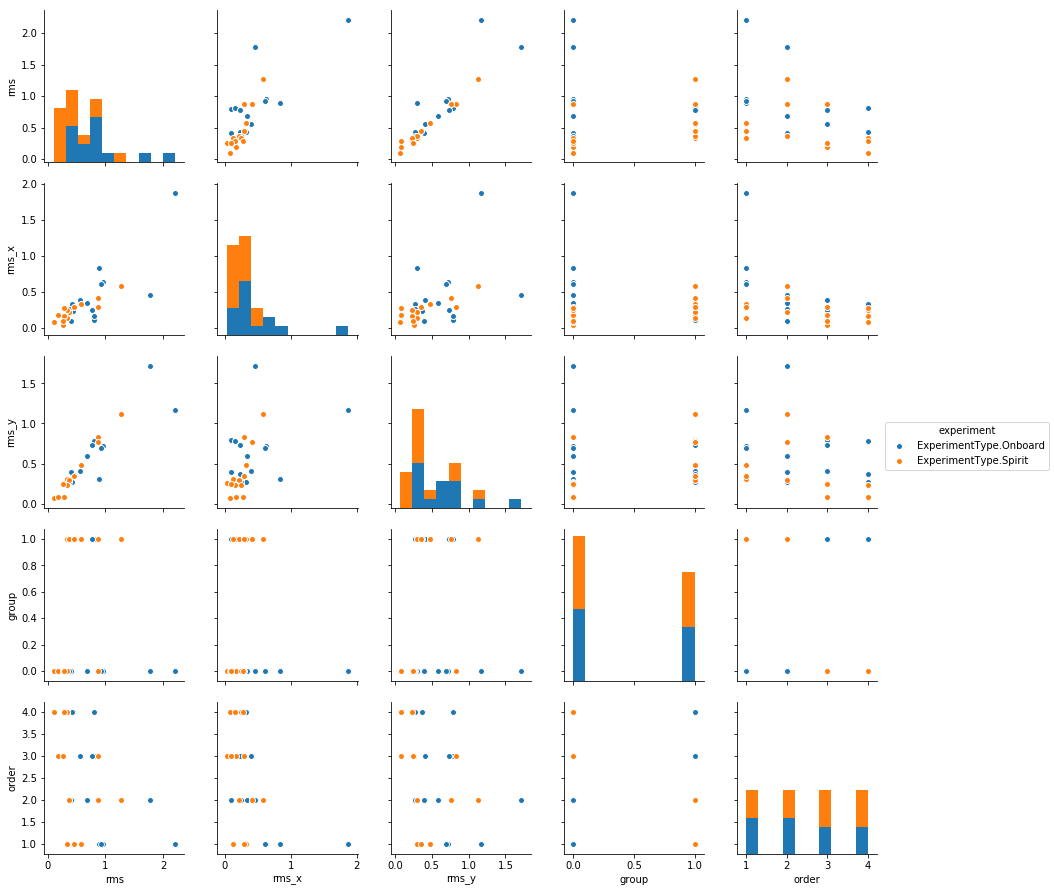

In [71]:
sns.pairplot(analyses[["rms", "rms_x", "rms_y", "group", "order", "experiment"]], hue="experiment")

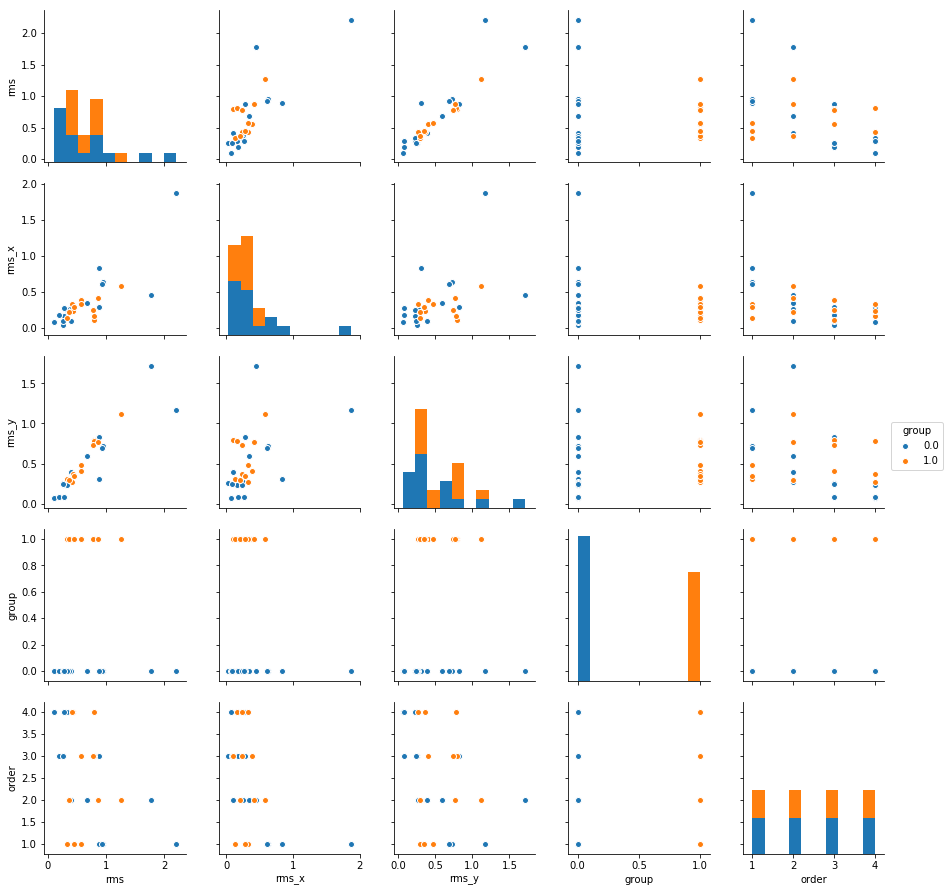

In [72]:
sns.pairplot(analyses[["rms", "rms_x", "rms_y", "group", "order", "experiment"]], hue="group")

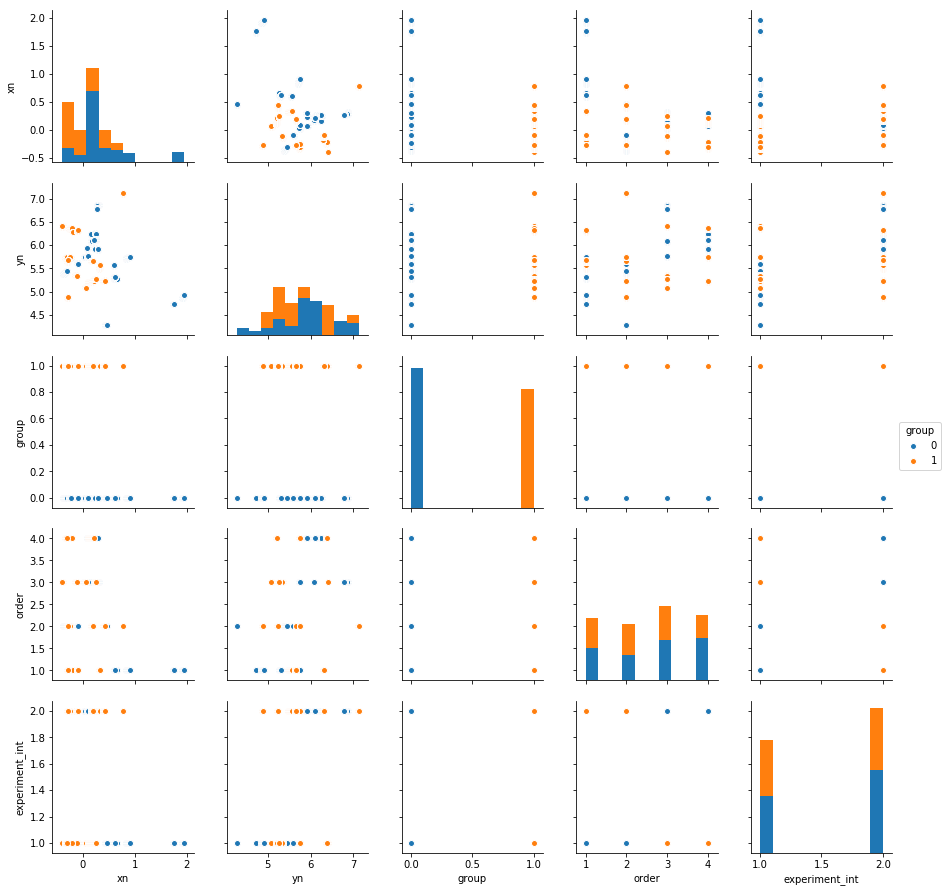

In [73]:
sns.pairplot(results[results.arrived==1][["xn", "yn", "group", "order", "experiment_int"]], hue="group")

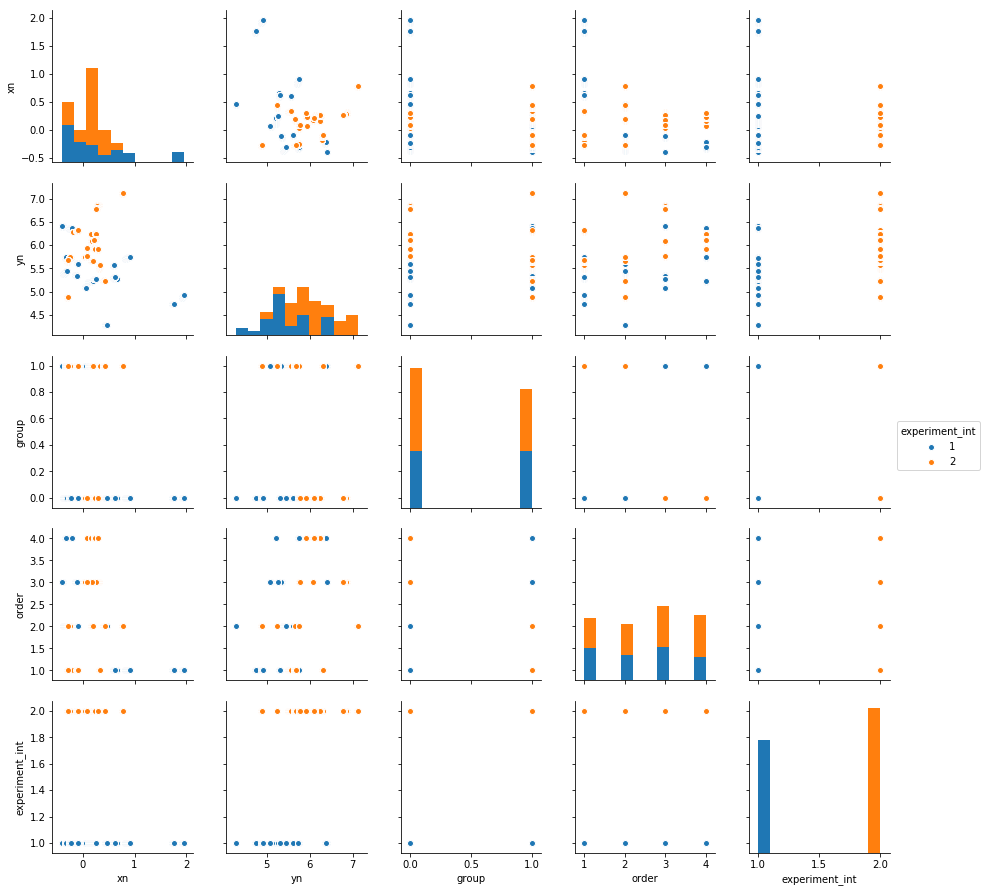

In [74]:
sns.pairplot(results[results.arrived==1][["xn", "yn", "group", "order", "experiment_int"]], hue="experiment_int")

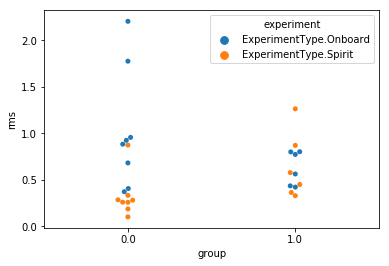

In [75]:
sns.swarmplot(x="group", y="rms", hue="experiment", data=analyses)

# SURVEYS!

In [13]:
import pickle

In [15]:
with open("data.pickle", "rb") as fin:
    data = pickle.load(fin)

In [22]:
for user in data:
    for experiment in user.experiments:
        print(experiment)

Experiment(Onboard, User #0)
Experiment(Spirit, User #0)
Experiment(Spirit, User #1)
Experiment(Onboard, User #1)
Experiment(Onboard, User #2)
Experiment(Spirit, User #2)
Experiment(Spirit, User #3)
Experiment(Onboard, User #3)
Experiment(Onboard, User #4)
Experiment(Spirit, User #4)
Experiment(Spirit, User #5)
Experiment(Onboard, User #5)
Experiment(Onboard, User #6)
Experiment(Spirit, User #6)


In [49]:
user.__dict__

{'age': '24',
 'experiments': [Experiment(Onboard, User #6), Experiment(Spirit, User #6)],
 'flying': '0',
 'id_': 6,
 'name': 'wen',
 'teleop': '0'}

In [50]:
experiment.__dict__

{'survey': <Survey()>,
 'tlx': <Tlx()>,
 'type_': <ExperimentType.Spirit: 2>,
 'user': User(#6, wen)}

In [55]:
experiment.survey.__dict__

{'longform': 'At first it is a little bit hard to control the orientation, then it is much better.',
 'questions': {'orientation_control': Question(orientation_control, 4),
  'orientation_understanding': Question(orientation_understanding, 4),
  'position_control': Question(position_control, 5),
  'position_understanding': Question(position_understanding, 6),
  'spacial_control': Question(spacial_control, 6),
  'spacial_understanding': Question(spacial_understanding, 6)}}

In [54]:
experiment.survey.questions["orientation_control"].__dict__

{'code': 'orientation_control',
 'description': 'Your control of the orientation of the drone',
 'score': 4}

In [56]:
experiment.tlx.__dict__

{'components': {'effort': Component(effort, 27),
  'frustration': Component(frustration, 5),
  'mental': Component(mental, 14),
  'performance': Component(performance, 15),
  'physical': Component(physical, 6),
  'temporal': Component(temporal, 14)}}

In [58]:
experiment.tlx.components["mental"].__dict__

{'code': 'mental',
 'description': '(Low to High) How mentally demanding was the task? / どの程度の知的、知覚的活動（考える、決める、計算する、記憶する、見る、など）を必要としましたか？課題はやさしかったですか、難しかったですか？単純でしたか、複雑でしたか？正確さが求められましたか、おおざっぱでよかったですか？',
 'name': 'Mental Demand / 知的・知覚的要求',
 'score': 7,
 'weight': 2}

In [41]:
{i.code:i.score for i in experiment.survey.questions.values()}

{'orientation_control': 4,
 'orientation_understanding': 4,
 'position_control': 5,
 'position_understanding': 6,
 'spacial_control': 6,
 'spacial_understanding': 6}

In [42]:
TlxResponse = namedtuple("TlxResponse", "code raw weight score")

In [47]:
def parse_tlx_component(component):
    return TlxResponse(component.code, component.score, component.weight, component.weighted_score)

In [48]:
parse_tlx_component(experiment.tlx.components["effort"])

TlxResponse(code='effort', raw=9, weight=3, score=27)

In [75]:
users = pd.DataFrame({"user_id": user.id_, "name": user.name, "age": user.age,
                       "teleop": user.teleop, "flying": user.flying} for user in data)
users

,age,flying,name,teleop,user_id
0,23,0,takemori,0,0
1,22,0,tsujimoto,0,1
2,22,0,yanagiya,0,2
3,29,0,sajid nisar,75,3
4,25,0,chen,10,4
5,24,0,kawai,0,5
6,24,0,wen,0,6


In [214]:
_tlx_data = []
for user in data:
    for experiment in user.experiments:
        d = {"user": user.id_, "experiment": experiment.type_}
        for component in experiment.tlx.components.values():
            parsed = parse_tlx_component(component)
            d[parsed.code] = parsed.score
        _tlx_data.append(d)
tlx = pd.DataFrame(_tlx_data)
tlx["group"] = tlx.user % 2
tlx["tlx"] = tlx.mental + tlx.physical + tlx.temporal + tlx.performance + tlx.effort + tlx.frustration
tlx["order"] = [1, 2]*(len(tlx)//2)
tlx["experiment_int"] = [e.value for e in tlx.experiment]

In [113]:
tlx

,effort,experiment,frustration,mental,performance,physical,temporal,user,group,tlx,order
0,14,ExperimentType.Onboard,56,10,42,0,60,0,0,182,1
1,18,ExperimentType.Spirit,30,8,16,0,6,0,0,78,2
2,4,ExperimentType.Spirit,10,20,10,0,0,1,1,44,1
3,15,ExperimentType.Onboard,12,16,6,0,0,1,1,49,2
4,57,ExperimentType.Onboard,54,32,20,0,10,2,0,173,1
5,33,ExperimentType.Spirit,45,28,30,0,3,2,0,139,2
6,9,ExperimentType.Spirit,5,15,25,0,6,3,1,60,1
7,16,ExperimentType.Onboard,0,15,20,3,4,3,1,58,2
8,20,ExperimentType.Onboard,36,64,16,0,5,4,0,141,1
9,20,ExperimentType.Spirit,30,60,6,0,5,4,0,121,2


In [174]:
_survey_data = []

for user in data:
    for experiment in user.experiments:
        d = {"user": user.id_, "experiment": experiment.type_}
        d.update({i.code:i.score for i in experiment.survey.questions.values()})
        _survey_data.append(d)

surveys = pd.DataFrame(_survey_data)
surveys["group"] = tlx.user % 2
surveys["order"] = [1, 2]*(len(surveys)//2)
surveys.head()

,experiment,orientation_control,orientation_understanding,position_control,position_understanding,spacial_control,spacial_understanding,user,group,order
0,ExperimentType.Onboard,5,5,2,2,1,2,0,0,1
1,ExperimentType.Spirit,4,4,6,5,6,5,0,0,2
2,ExperimentType.Spirit,4,5,3,5,4,6,1,1,1
3,ExperimentType.Onboard,4,4,2,4,2,2,1,1,2
4,ExperimentType.Onboard,2,4,2,2,1,1,2,0,1


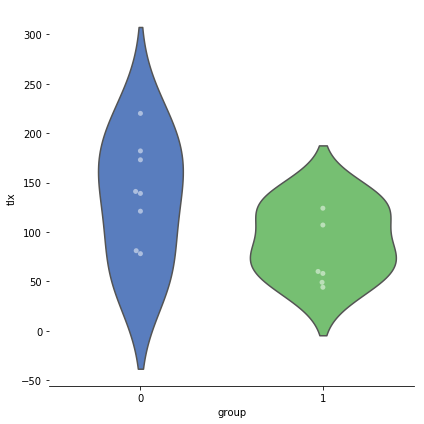

In [226]:
g = sns.factorplot(x="experiment", y="tlx", data=tlx,
                   size=6, kind="violin", palette="muted", split=True, inner=None)
sns.swarmplot(x="group", y="tlx", data=tlx, color="w", alpha=.5)
g.despine(left=True)

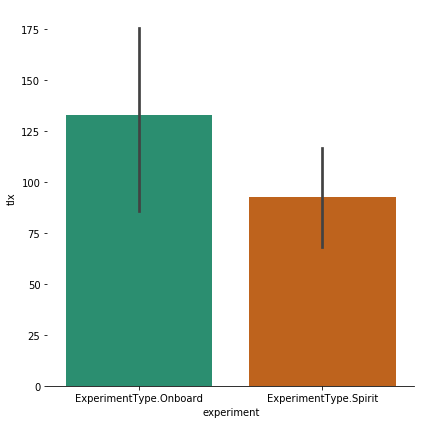

In [204]:
g = sns.factorplot(x="experiment", y="tlx", data=tlx,
                   size=6, kind="bar", palette="Dark2")
g.despine(left=True)

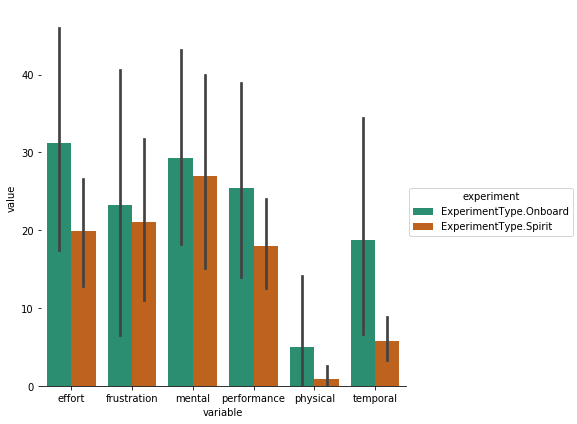

In [203]:
g = sns.factorplot(x="variable", y="value", hue="experiment",
                   data=pd.melt(tlx, id_vars=["user", "experiment", "group", "tlx", "order"]),
                   size=6, kind="bar", palette="Dark2")
g.despine(left=True)

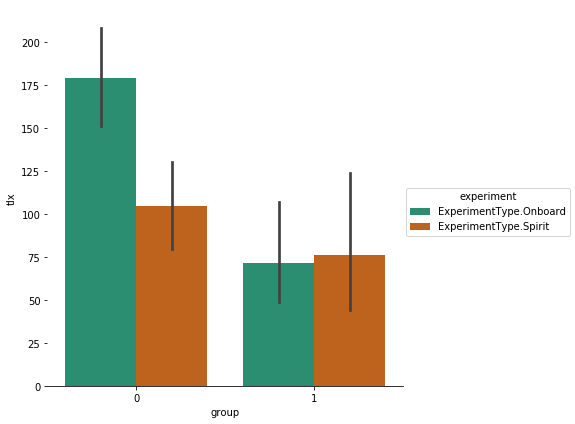

In [202]:
g = sns.factorplot(x="group", y="tlx", hue="experiment", data=tlx,
                   size=6, kind="bar", palette="Dark2")
g.despine(left=True)

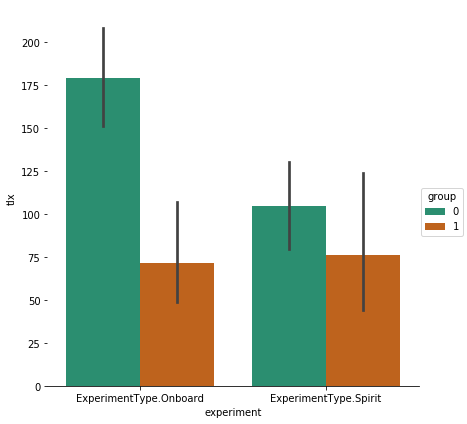

In [238]:
g = sns.factorplot(x="experiment", y="tlx", hue="group", data=tlx,
                   size=6, kind="bar", palette="Dark2")
g.despine(left=True)

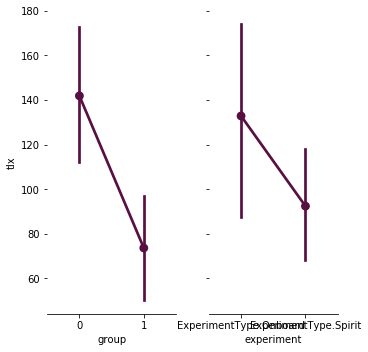

In [119]:
g = sns.PairGrid(tlx, y_vars="tlx",
                 x_vars=["group", "experiment"],
                 size=5, aspect=.5)

# Draw a seaborn pointplot onto each Axes
g.map(sns.pointplot, color=sns.xkcd_rgb["plum"])
sns.despine(fig=g.fig, left=True)

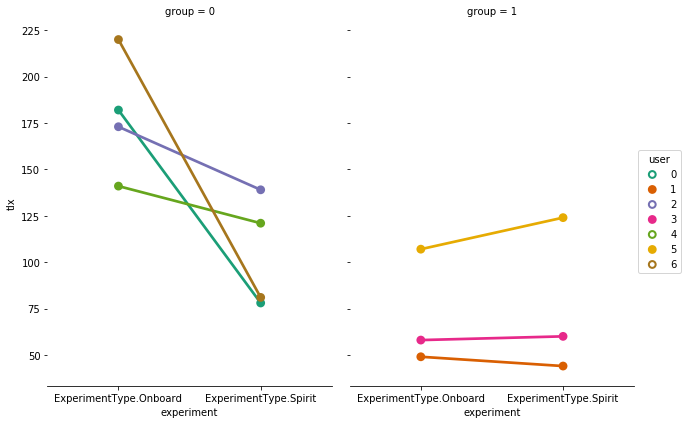

In [124]:
g = sns.factorplot(x="experiment", y="tlx", col="group", hue="user", data=tlx,
                   capsize=.2, palette="Dark2", size=6, aspect=.75)
g.despine(left=True)

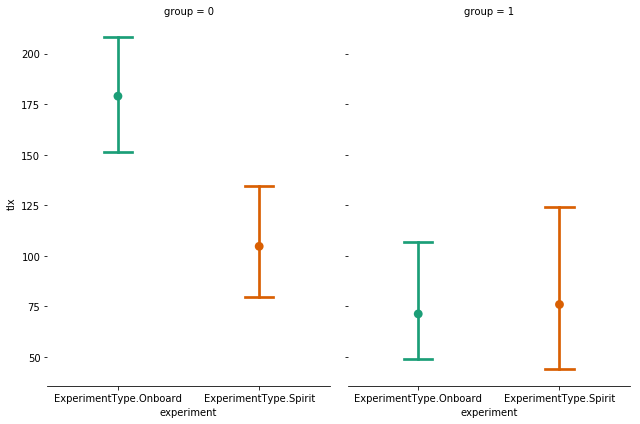

In [127]:
g = sns.factorplot(x="experiment", y="tlx", col="group", data=tlx,
                   capsize=.2, palette="Dark2", size=6, aspect=.75)
g.despine(left=True)

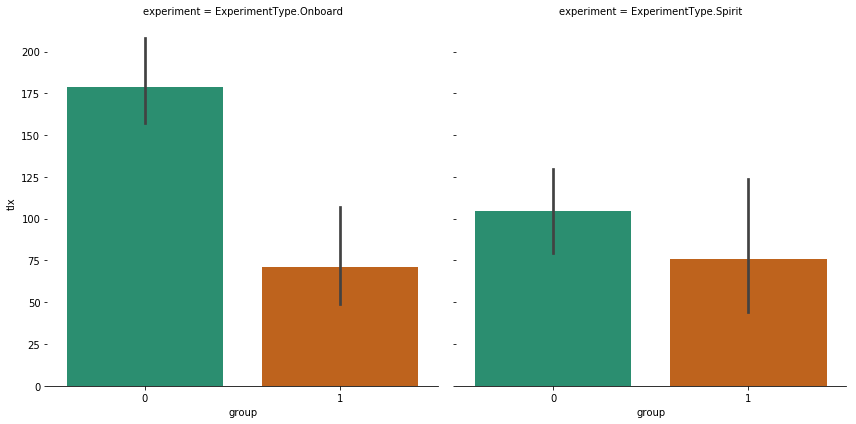

In [177]:
g = sns.factorplot(x="group", y="tlx", col="experiment", data=tlx,
                   size=6, kind="bar", palette="Dark2")
g.despine(left=True)

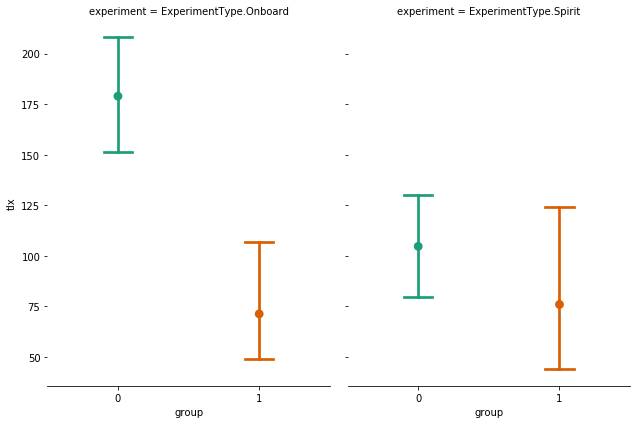

In [126]:
g = sns.factorplot(x="group", y="tlx", col="experiment", data=tlx,
                   capsize=.2, palette="Dark2", size=6, aspect=.75)
g.despine(left=True)

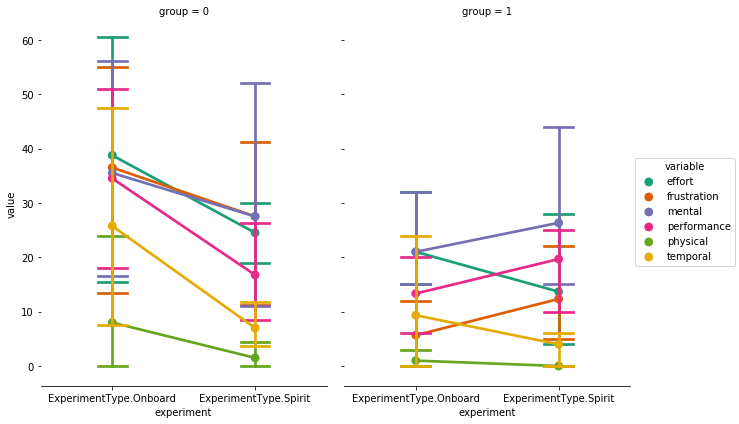

In [134]:
g = sns.factorplot(x="experiment", y="value", col="group", hue="variable",
                   data=pd.melt(tlx, id_vars=["user", "experiment", "group", "tlx", "order"]),
                   capsize=.2, palette="Dark2", size=6, aspect=.75)
g.despine(left=True)

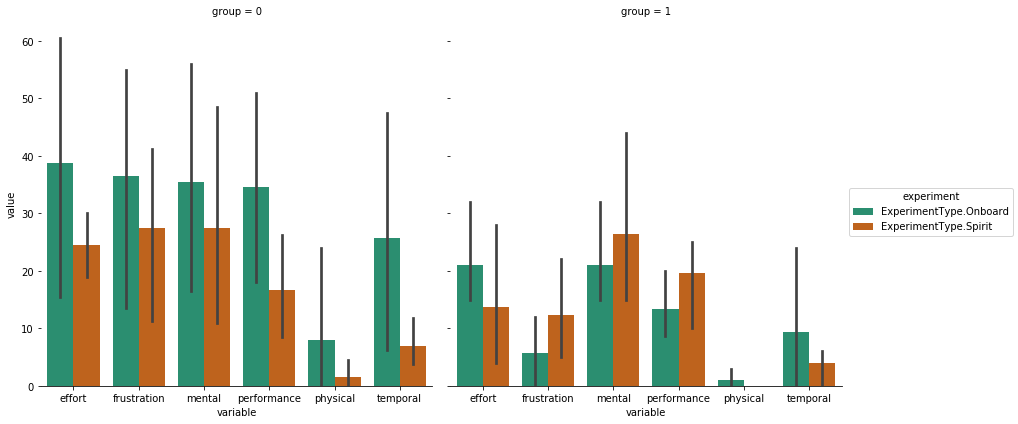

In [179]:
g = sns.factorplot(x="variable", y="value", hue="experiment", col="group",
                   data=pd.melt(tlx, id_vars=["user", "experiment", "group", "tlx", "order"]),
                   size=6, kind="bar", palette="Dark2")
g.despine(left=True)

In [151]:
surveys

,experiment,orientation_control,orientation_understanding,position_control,position_understanding,spacial_control,spacial_understanding,user,group,order
0,ExperimentType.Onboard,5,5,2,2,1,2,0,0,1
1,ExperimentType.Spirit,4,4,6,5,6,5,0,0,2
2,ExperimentType.Spirit,4,5,3,5,4,6,1,1,1
3,ExperimentType.Onboard,4,4,2,4,2,2,1,1,2
4,ExperimentType.Onboard,2,4,2,2,1,1,2,0,1
5,ExperimentType.Spirit,4,5,3,4,4,5,2,0,2
6,ExperimentType.Spirit,3,3,4,4,6,5,3,1,1
7,ExperimentType.Onboard,5,5,5,5,5,2,3,1,2
8,ExperimentType.Onboard,6,6,5,5,4,3,4,0,1
9,ExperimentType.Spirit,6,6,6,6,6,6,4,0,2


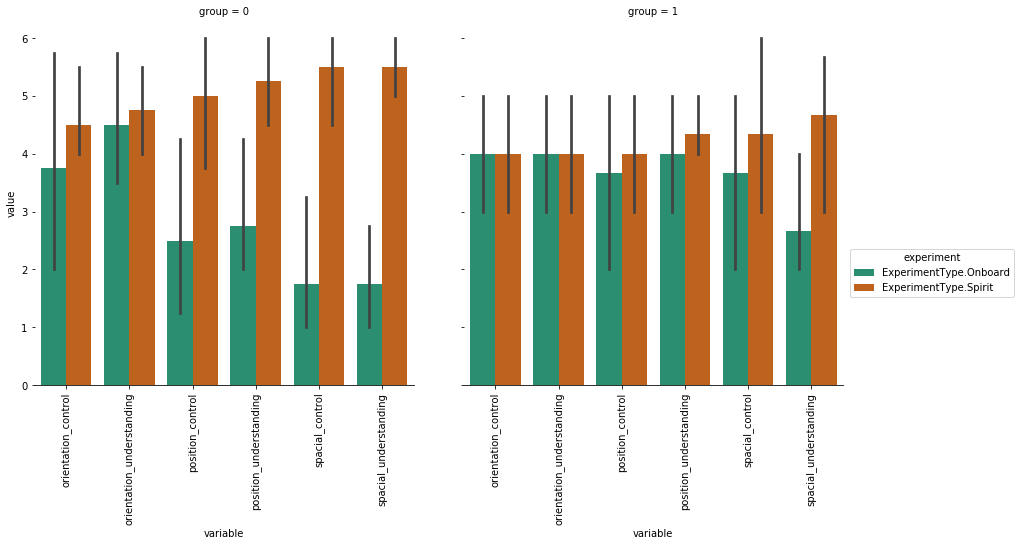

In [232]:
g = sns.factorplot(x="variable", y="value", hue="experiment", col="group",
                   data=pd.melt(surveys, id_vars=["user", "experiment", "group", "order"]),
                   size=6, kind="bar", palette="Dark2")
g.set_xticklabels(rotation=90)
g.despine(left=True)

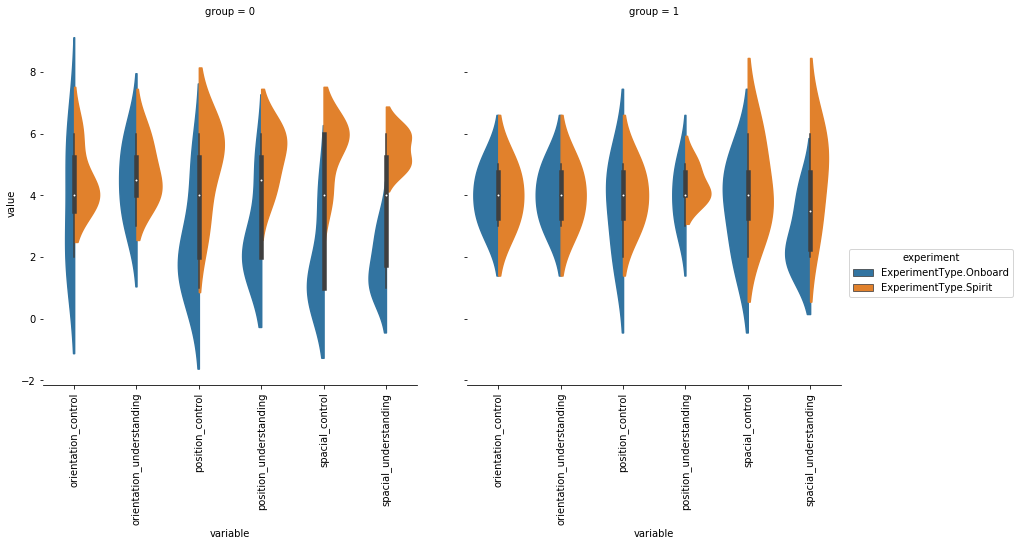

In [234]:
g = sns.factorplot(x="variable", y="value", hue="experiment", col="group",
                   data=pd.melt(surveys, id_vars=["user", "experiment", "group", "order"]),
                   size=6, kind="violin", split=True)

g.set_xticklabels(rotation=90)
g.despine(left=True)